In [1]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean, median
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import StratifiedKFold
from math import sqrt


from sklearn.preprocessing import StandardScaler
sns.set_style("whitegrid")

In [2]:
url = 'imdbStat.csv'
data = pd.read_csv(url)
data = data.drop('Unnamed: 0', axis=1)
data

,movie,year,imdb_rate,metascore,votes,rating,genre,runtime_min,grosess
0,The Creator,2023,7.2,63,"31,781",PG-13,"['Action', ' Adventure', ' Drama']",133,-
1,No One Will Save You,2023,6.3,60,"34,685",PG-13,"['Horror', ' Sci-Fi', ' Thriller']",93,-
2,Meg 2: The Trench,2023,5.1,40,"54,356",PG-13,"['Action', ' Adventure', ' Horror']",116,-
3,Elemental,2023,7.0,58,"81,559",PG,"['Animation', ' Adventure', ' Comedy']",101,-
4,PAW Patrol: The Mighty Movie,2023,6.0,52,"1,447",PG,"['Animation', ' Action', ' Adventure']",88,-
...,...,...,...,...,...,...,...,...,...
1398,GoBots: Battle of the Rock Lords,1986,5.4,30,539,G,"['Animation', ' Action', ' Adventure']",75,$1.34M
1399,Uncle Kent 2,2015,5.3,54,246,Unrated,"['Comedy', ' Sci-Fi']",73,-
1400,Hangar 10,2014,3.6,28,"1,618",Not Rated,"['Horror', ' Sci-Fi', ' Thriller']",87,-
1401,Napping Princess,2017,6.3,69,"1,509",NaN,"['Animation', ' Adventure', ' Drama']",111,$0.05M


## Обработка данных

Первое, что нужно сделать, это разобраться с "genre": у нас тут массив жанров, который пока вносит ноль информативности. 

In [3]:
# поменяли запятые на точки
data['votes'] = data['votes'].str.replace(',','')
data['votes'] = data['votes'].apply(lambda x : float(x))
# дропнем grosess, так как имет много пропусков 
data = data.drop('grosess', axis=1)

In [4]:
# убрала у каждого жанра пробелы и превратила в лист листов
genre = data['genre'].to_numpy()
new_genres = []
for i in genre:
    one_str = i.strip("[]").split(", ")
    arr_one_str = []
    for j in one_str:
        j = j.replace("'", "")
        j = j.replace(" ", "")
        arr_one_str.append(j)
    new_genres.append(arr_one_str)
data['genre'] = new_genres


In [5]:
# преобразовываем признак 'genre' в новые признаки
data_genres = data[['genre']]
data_genres = data_genres.dropna(subset = 'genre')

data_genres = data_genres.reset_index()

dum = pd.get_dummies(
  data_genres.join(pd.Series(data_genres['genre'].apply(pd.Series).stack().reset_index(1, drop=True),
                    name='Genre1')).drop('genre', axis=1).rename(columns={'Genre1': 'Genre'}),
  columns=['Genre']).groupby('index', as_index=False).sum()

In [6]:
# мерджим новые признаки и старый датафрейм
data = data.reset_index()
data = pd.merge(data, dum, on='index') 
data = data.drop(['index', 'genre'], axis=1)
data

,movie,year,imdb_rate,metascore,votes,rating,runtime_min,Genre_Action,Genre_Adventure,Genre_Animation,...,Genre_History,Genre_Horror,Genre_Music,Genre_Musical,Genre_Mystery,Genre_Romance,Genre_Sci-Fi,Genre_Sport,Genre_Thriller,Genre_War
0,The Creator,2023,7.2,63,31781.0,PG-13,133,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,No One Will Save You,2023,6.3,60,34685.0,PG-13,93,0,0,0,...,0,1,0,0,0,0,1,0,1,0
2,Meg 2: The Trench,2023,5.1,40,54356.0,PG-13,116,1,1,0,...,0,1,0,0,0,0,0,0,0,0
3,Elemental,2023,7.0,58,81559.0,PG,101,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,PAW Patrol: The Mighty Movie,2023,6.0,52,1447.0,PG,88,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1398,GoBots: Battle of the Rock Lords,1986,5.4,30,539.0,G,75,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1399,Uncle Kent 2,2015,5.3,54,246.0,Unrated,73,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1400,Hangar 10,2014,3.6,28,1618.0,Not Rated,87,0,0,0,...,0,1,0,0,0,0,1,0,1,0
1401,Napping Princess,2017,6.3,69,1509.0,NaN,111,0,1,1,...,0,0,0,0,0,0,0,0,0,0


### Неочевидный шаг

Сначала я подумала, что самое очевидное, что можно прогнозировать, это рейтинг или бюджет фильма, но со вторым много пропусков, а первый слишком очевидный, чтобы его прогнозировать.

Тогда давайте возьмем за таргет продолжительность фильма

In [7]:
target = data['runtime_min']
X = data.drop('runtime_min', axis=1)

## Анализ данных





### Распределения признаков и таргета

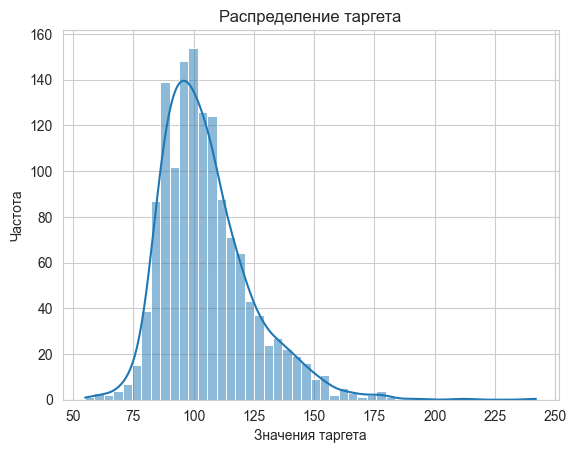

In [8]:
sns.histplot(data['runtime_min'], kde=True)
plt.xlabel('Значения таргета')
plt.ylabel('Частота')
plt.title('Распределение таргета')
plt.show()

В распределении таргета наблюдается маленькая не сбалансированность. 

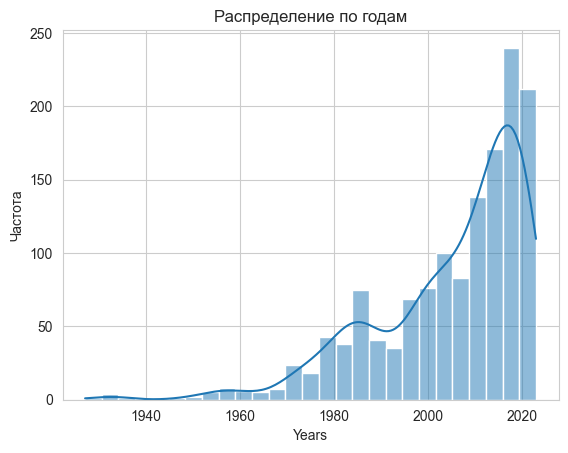

In [9]:
sns.histplot(data['year'], kde=True)
plt.xlabel('Years')
plt.ylabel('Частота')
plt.title('Распределение по годам')
plt.show()

Исходя из вышеуказанных графиков, можно увидеть, что признак "years" достаточно не сбалансирован, хотя это логично и без графиков. В зависимости от модели, которую я выберу, стоит сделать взвешивание классов, то есть  назначить различные веса классам, чтобы уровнять их влияние на ml-модель. Это можно сделать, например, путем использования параметра "class_weight" в модели (если такой параметр имеется).

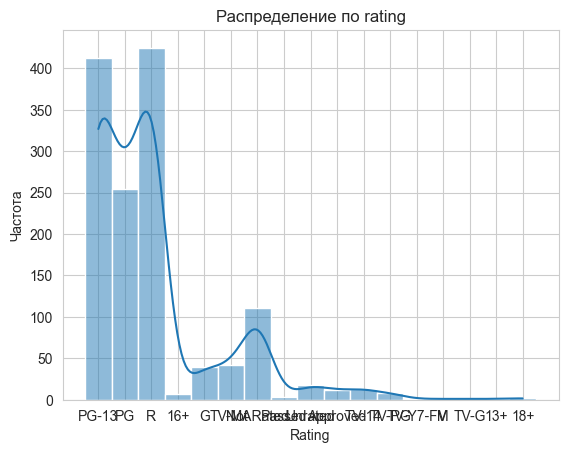

In [10]:
sns.histplot(data['rating'], kde=True)
plt.xlabel('Rating')
plt.ylabel('Частота')
plt.title('Распределение по rating')
plt.show()

Да, тут плохо отображаются ratings, но и без того можно понять, что это супер несбалансированный признак. В зависимости от кореляции этого признака и таргета, нужно будет понять, нужно ли и как обрабатывать эту проблему.

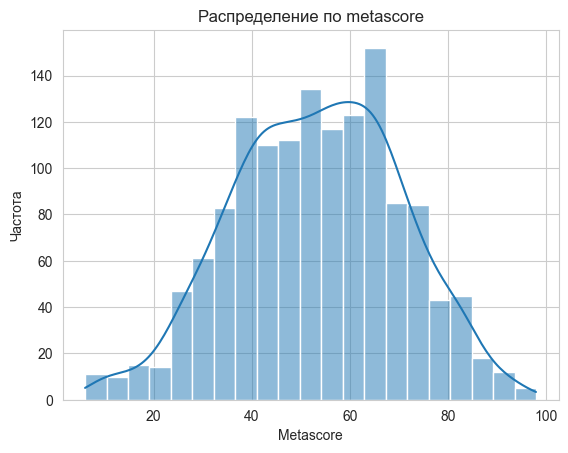

In [11]:
sns.histplot(data['metascore'], kde=True)
plt.xlabel('Metascore')
plt.ylabel('Частота')
plt.title('Распределение по metascore')
plt.show()

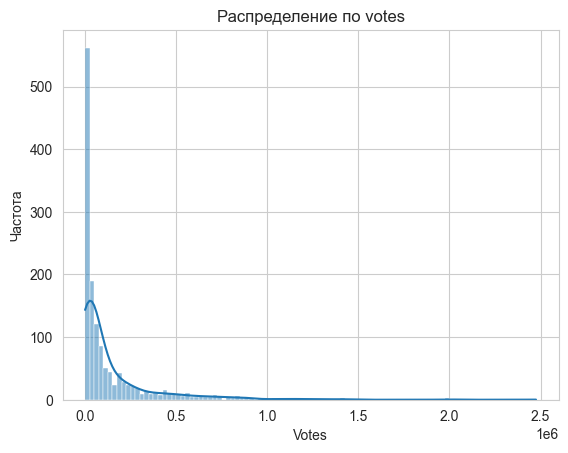

In [12]:
sns.histplot(data['votes'], kde=True)
plt.xlabel('Votes')
plt.ylabel('Частота')
plt.title('Распределение по votes')
plt.show()

Ожидаемая сбалансированность, в целом.

### Тепловая карта 

Тепловая карта показывают, существует ли линейная зависимость между столбцами в датафрейме.

<Axes: >

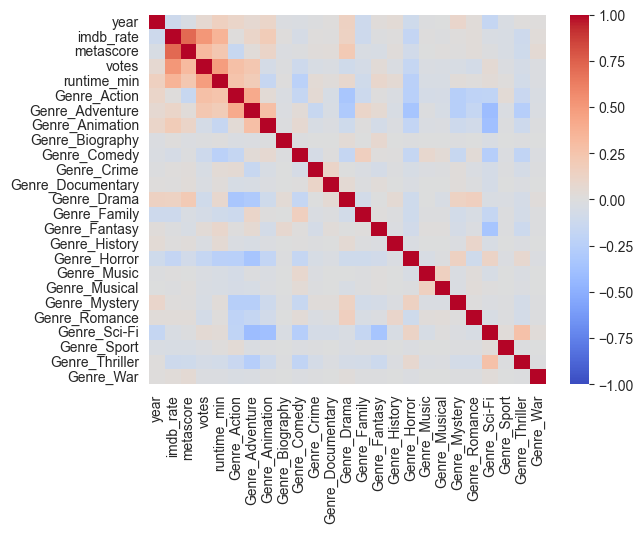

In [13]:
data_for_heatmap = data
data_for_heatmap = data_for_heatmap.drop(['movie', 'rating'], axis=1)
sns.heatmap(data_for_heatmap.corr(), vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

### Таблица корреляций Спирмана

Показывает, существует ли нелинейная корреляция между столбцами датафрейма

In [14]:
correlation = data_for_heatmap.corr(method='spearman')
correlation

,year,imdb_rate,metascore,votes,runtime_min,Genre_Action,Genre_Adventure,Genre_Animation,Genre_Biography,Genre_Comedy,...,Genre_History,Genre_Horror,Genre_Music,Genre_Musical,Genre_Mystery,Genre_Romance,Genre_Sci-Fi,Genre_Sport,Genre_Thriller,Genre_War
year,1.000000,-0.095354,0.057931,-0.058314,0.160014,0.042255,0.059497,0.084025,-0.026356,-0.050934,...,0.052472,-0.070611,-0.012320,-0.004492,0.081247,0.024682,-0.160284,-0.040017,0.015387,0.011877
imdb_rate,-0.095354,1.000000,0.704892,0.503654,0.348042,0.020428,0.111235,0.206725,0.012304,-0.051959,...,0.004904,-0.187900,0.004748,-0.008391,0.005118,0.018516,-0.033583,-0.021093,-0.123364,0.030777
metascore,0.057931,0.704892,1.000000,0.213569,0.209956,-0.159078,0.023980,0.109830,-0.021336,-0.001930,...,0.021771,-0.087160,-0.004122,0.012839,0.006486,0.024746,-0.009713,-0.028901,-0.103631,0.052973
votes,-0.058314,0.503654,0.213569,1.000000,0.466458,0.371857,0.294348,-0.033589,-0.008111,-0.088190,...,-0.085255,-0.134140,-0.028399,-0.075512,-0.021594,-0.095385,-0.007280,-0.010542,-0.090919,-0.041887
runtime_min,0.160014,0.348042,0.209956,0.466458,1.000000,0.261227,0.181128,-0.172455,0.015401,-0.238454,...,0.030273,-0.241485,-0.046117,-0.042647,0.033500,0.032373,0.050803,0.017705,-0.066697,-0.018965
Genre_Action,0.042255,0.020428,-0.159078,0.371857,0.261227,1.000000,0.409819,0.042144,-0.025099,-0.170963,...,-0.023465,-0.248890,-0.066549,-0.061590,-0.250881,-0.206912,-0.200340,0.040203,-0.143155,-0.035508
Genre_Adventure,0.059497,0.111235,0.023980,0.294348,0.181128,0.409819,1.000000,0.281464,-0.021381,0.034806,...,-0.042808,-0.348527,-0.015222,-0.052467,-0.253774,-0.169320,-0.407267,-0.030248,-0.261738,-0.030248
Genre_Animation,0.084025,0.206725,0.109830,-0.033589,-0.172455,0.042144,0.281464,1.000000,-0.008927,0.066152,...,-0.017873,-0.182762,-0.023669,-0.021906,-0.117130,-0.088031,-0.382961,-0.012629,-0.115219,-0.012629
Genre_Biography,-0.026356,0.012304,-0.021336,-0.008111,0.015401,-0.025099,-0.021381,-0.008927,1.000000,-0.014811,...,-0.001428,-0.015046,-0.001891,-0.001750,-0.010473,-0.007034,-0.033712,-0.001009,-0.009206,-0.001009
Genre_Comedy,-0.050934,-0.051959,-0.001930,-0.088190,-0.238454,-0.170963,0.034806,0.066152,-0.014811,1.000000,...,0.001865,-0.167020,0.079985,0.040915,-0.153199,0.038184,-0.261540,-0.020953,-0.191162,-0.020953


Что мы видим? 
- самая сильная корреляция очевидно между imdb_rate и metascore. На моем опыте какой-то из этих признаков лучше выкинуть, чтобы улучшить обучаемость на на тренировочном наборе.

P.S. это и так было очевидно, но мне захотелось проверить все столбцы датафрейма

In [15]:
data = data.drop('metascore', axis=1)
data = data.drop("rating", axis=1)

## Масштабирование



In [16]:
data.describe(include='all')

,movie,year,imdb_rate,votes,runtime_min,Genre_Action,Genre_Adventure,Genre_Animation,Genre_Biography,Genre_Comedy,...,Genre_History,Genre_Horror,Genre_Music,Genre_Musical,Genre_Mystery,Genre_Romance,Genre_Sci-Fi,Genre_Sport,Genre_Thriller,Genre_War
count,1403,1403.000000,1403.000000,1.403000e+03,1403.000000,1403.000000,1403.000000,1403.000000,1403.000000,1403.000000,...,1403.000000,1403.000000,1403.000000,1403.000000,1403.000000,1403.000000,1403.000000,1403.000000,1403.000000,1403.000000
unique,1366,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Godzilla,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2005.006415,6.122594,1.383387e+05,105.204562,0.468995,0.390592,0.100499,0.000713,0.235210,...,0.002851,0.240912,0.004989,0.004277,0.133286,0.064861,0.614398,0.001426,0.106201,0.001426
std,NaN,16.073896,1.065258,2.384197e+05,18.969874,0.499216,0.488057,0.300771,0.026698,0.424281,...,0.053338,0.427790,0.070484,0.065279,0.340005,0.246368,0.486911,0.037743,0.308205,0.037743
min,NaN,1927.000000,1.500000,4.400000e+01,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,1997.000000,5.500000,1.018500e+04,92.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,2011.000000,6.200000,4.138700e+04,102.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,NaN,2017.000000,6.800000,1.512015e+05,114.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000


Из очевидного: лучше промасштабировать grosess в независимости от выбранной модели, потому что моделям, которым пофиг на масштабирование, будет наплевать и после него на это, а другим моделям очевидно это понадобится.

Чтобы понять, какой из видов масштабирования использовать, давайте проверим на нормальное распределение пару признаков и таргет:
- по гистограммам можно понять, что rating, year, votes имеют НЕ нормальное распределение, а вот target уже ближе к нему.
- тогда давайте по boxplot проверим, насколько target близки к нему.

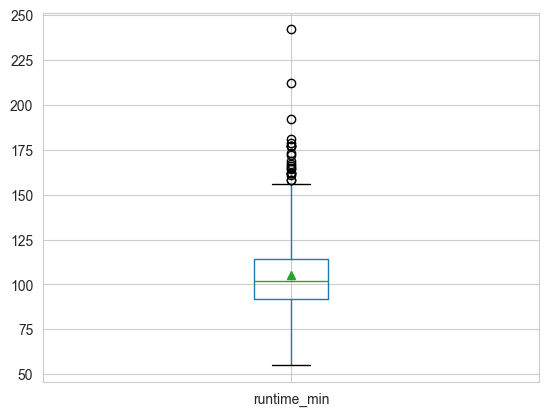

In [17]:
def get_boxplot(xs):
    pd.DataFrame(xs).boxplot(sym='o', whis=1.95, showmeans=True)
    plt.show()

get_boxplot(data['runtime_min'])


Видно, что медиана и среднее арифметическое не сильно совпадают с друг другом на графике таргета, значит и таргет имеет лишь "похожее" распределение на нормальное.

#### Спрашивается, зачем я это всё делала, для чего нужны были эти гистограммы и ящики с усами?

- во-первых, от распределения зависит то, как мне нужно масштабировать данные: с помощью нормализации или стандартизации.
- во-вторых, некоторые алгоритмы требуют, чтобы данные имели нормальное распределение (например, K-Nearest Neighbours). Значит, от этого зависит выбор алгоритма.
- в-третьих, это поможет мне обработать найти выбросы (не все выборсы могут быть выбросами) и обработать их.
- в-четвертых, при выборе метрики в дальнейшем я буду опираться на эти графики

Я пришла к выводу, что большинство данных имеют какое угодное распределение, но точно не нормальное => используем нормализацию.

In [18]:
data = data.set_index('movie')

In [19]:
scaler = MinMaxScaler()
to_scaled = ['votes', 'runtime_min', 'imdb_rate', 'year']
scaled_data = data
scaled_data[to_scaled] = scaler.fit_transform(data[to_scaled])
scaled_data

,year,imdb_rate,votes,runtime_min,Genre_Action,Genre_Adventure,Genre_Animation,Genre_Biography,Genre_Comedy,Genre_Crime,...,Genre_History,Genre_Horror,Genre_Music,Genre_Musical,Genre_Mystery,Genre_Romance,Genre_Sci-Fi,Genre_Sport,Genre_Thriller,Genre_War
movie,,,,,,,,,,,,,,,,,,,,,
The Creator,1.000000,0.780822,0.012823,0.417112,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
No One Will Save You,1.000000,0.657534,0.013997,0.203209,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0
Meg 2: The Trench,1.000000,0.493151,0.021945,0.326203,1,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
Elemental,1.000000,0.753425,0.032937,0.245989,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
PAW Patrol: The Mighty Movie,1.000000,0.616438,0.000567,0.176471,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GoBots: Battle of the Rock Lords,0.614583,0.534247,0.000200,0.106952,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Uncle Kent 2,0.916667,0.520548,0.000082,0.096257,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
Hangar 10,0.906250,0.287671,0.000636,0.171123,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0


## Модель

Теперь давайте перейдем к выбору модели машинного обучения. 

Определимся, какие модели лучше всего потестить:

1) **KNN**: 
- Чем он хорош? Удобно и понятно применять на маленьких датасетах. Достаточно точный, хоть и чаще всего уступает градиентному бустингу и случайному лесу в accuracy.
- Вычислительно дорогой и неэффективный по памяти. Чувствителен к масштабу данных, а также к неинформативным признакам, коих у меня в датасете может быть много.

2) **Линейная регрессия**: я выяснила по корреляции Пирсона на тепловой карте, что либо линейной связи нет, либо она слишком слабая => значит существует нелинейная зависимость. Да, можно, конечно, преобразовать признаковое пространство (ex: возвести в квадрат), но для этого нужно примерно предополагать нелинейную зависимость или попробовать пообучать на разных преобразованных признаковых пространствах => не очень удобно. Кажется, что на моем датасете можно придумать более результативное и понятное решение.

3) **Деревья решений**: 
- К нему стоит прибегнуть, если обрабатывать данные тяжело и хочется наглядно понять, почему алгоритм делает именно такие выводы. К тому же мы можем спокойно работать как с категориальными, так и с числовыми признаками, так как в случае категориальных берется просто класс для разделения, а в случае количественных признаков берется порог.
- Когда не стоит его выбирать? Если наблюдается большая несбалансированность в классах (например: 500 объектов одного класса, 20 объектов другого класса, то алгоритм будет иметь сильно предвзято решение). Да, несбалансированность можно убрать, но а) не всегда это возможно, б) не всегда это хочется делать. Вряд ли тут стоит говорить про большие затраты по памяти и времени, потому что у многих получились сравнительно маленькие датасеты (маленькие датасеты ~ несколько десятков тысяч строк), про свой я вообще молчу. К тому же они не очень подходят для непрерывных переменных (т. е. переменных, которые могут иметь более одного значения или спектр значений). А ещё дерево решений сильно подвержена переобучению, то есть оно разрастается до таких размеров, когда листьев много, а объектов в них мало (почему это плохо? в таком случае дерево просто предсказывает частные случаи).Однако стоит заметить, что существует множество способов не допустить это: ограничение на глубину, ограничение на количество листьев и объектов в них и тд. 

4) **Ансамбль**: хороший результат зависит от выбора стратегии (бэггинг (ex: случайный лес), стэкинг, бустинг (ex: все модицифкации градиентного бустинга)). Вообще в среднем ансамбли показывают более хорошие результаты чем остальные модели классического ml, но иногда их можно не использовать, так как это просто не требуется в силу несложных данных и зависимостей между признаками и таргетом.

### Разбивка на тренировочный и тестовый набор

Я не вижу смысла разбивать еще и на валидационный, так как я собираюсь использовать GridSearhCV

In [20]:
data = data.to_numpy()
target = target.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=1)

### Дерево SKLearn

In [21]:
def mse(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.square(np.subtract(actual,pred)).mean() 

tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)

result = tree.predict(X_test)

print("MSE: ", sqrt(mse(y_test, result)))
print("MSE norm: ", sqrt(mse(y_test, result))/187)

MSE:  0.3898961430628635
MSE norm:  0.002085006112635634


In [22]:
params = {'criterion' : ['squared_error', 'friedman_mse'],
         'max_depth' : [3,4,6,7],
         'min_samples_split' : [2,4,6],
         'max_features' : [5,8,10,18,23]}

skf = StratifiedKFold(n_splits=3)

gv = GridSearchCV(tree, params, cv=skf)

gv.fit(X_train, y_train)

result_gv = gv.predict(X_test)

print("MSE: ", sqrt(mse(y_test, result_gv)))
print("MSE norm: ", sqrt(mse(y_test, result_gv))/187)

/Users/anastasiaspileva/Library/Python/3.10/lib/python/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


MSE:  0.6518840571482835
MSE norm:  0.0034860110007929597


## Имплементированное дерево решений

In [23]:
def variance(y):
    return np.var(y)

def mad_median(y):
    return np.mean(np.abs(y - np.median(y)))

criteria_dict = {
    "variance": variance,
    "mad_median": mad_median,
}

def regression_leaf(y):
    return np.mean(y)

class Node:
    def __init__(self, feature_idx=0, threshold=0, labels=None, left=None, right=None):
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.labels = labels
        self.left = left
        self.right = right
    

In [24]:
class DecisionTree(BaseEstimator):
    def __init__(self, max_depth=np.inf, min_samples_split=2, criterion="variance"):
        params = {
            "max_depth": max_depth,
            "min_samples_split": min_samples_split,
            "criterion": criterion
        }
        for param_name, param_value in params.items():
            setattr(self, param_name, param_value)

        super(DecisionTree, self).set_params(**params)
        self._criterion_function = criteria_dict[criterion]
        self._leaf_value = regression_leaf

    def _functional(self, X, y, feature_idx, threshold):
        mask = X[:, feature_idx] < threshold
        n_obj = X.shape[0]
        n_left = np.sum(mask)
        n_right = n_obj - n_left
        if n_left > 0 and n_right > 0:
            return (
                self._criterion_function(y)
                - (n_left / n_obj) * self._criterion_function(y[mask])
                - (n_right / n_obj) * self._criterion_function(y[~mask])
            )
        else:
            return 0
        
    def _build_tree(self, X, y, depth=1):
        max_functional = 0
        best_feature_idx = None
        best_threshold = None
        n_samples, n_features = X.shape

        if len(np.unique(y)) == 1:
            return Node(labels=y)

        if depth < self.max_depth and n_samples >= self.min_samples_split:

            for feature_idx in range(n_features):
                threshold_values = np.unique(X[:, feature_idx])
                functional_values = [
                    self._functional(X, y, feature_idx, threshold) for threshold in threshold_values
                ]

                best_threshold_idx = np.nanargmax(functional_values)

                if functional_values[best_threshold_idx] > max_functional:
                    max_functional = functional_values[best_threshold_idx]
                    best_threshold = threshold_values[best_threshold_idx]
                    best_feature_idx = feature_idx
                    best_mask = X[:, feature_idx] < best_threshold

        if best_feature_idx is not None:
            return Node(
                feature_idx=best_feature_idx,
                threshold=best_threshold,
                left=self._build_tree(X[best_mask, :], y[best_mask], depth + 1),
                right=self._build_tree(X[~best_mask, :], y[~best_mask], depth + 1),
            )
        else:
            return Node(labels=y)

    def fit(self, X, y):
        self.root = self._build_tree(X, y)
        return self

    def _predict_object(self, x, node=None):
        node = self.root

        while node.labels is None:
            if x[node.feature_idx] < node.threshold:
                node = node.left
            else:
                node = node.right
        return self._leaf_value(node.labels)

    def predict(self, X):
        return np.array([self._predict_object(x) for x in X])

In [25]:
my_tree = DecisionTree()
my_tree.fit(X_train, y_train)
my_result = my_tree.predict(X_test)
print("RMSE: ", sqrt(mse(y_test, my_result)))
print("RMSE norm: ", sqrt(mse(y_test, my_result))/187)

RMSE:  0.5338872815994793
RMSE norm:  0.002855012201066734
